In [1]:
import pandas as pd
from pymorphy3 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation

import os
import string
import annoy
import codecs
import re

from gensim.models import Word2Vec

import numpy as np
from tqdm.notebook import tqdm

from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

import pickle
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics

In [2]:
df_prod = pd.read_csv('data/ProductsDataset.csv')

Вытаскиваем первые 200000 вопросов, затем сохранение в файл, ибо очень долго обрабатывается, причина ограничения по числу так же в долгой обработке

In [ ]:
#question = None
#written = False
#df_question = pd.DataFrame(columns=['question', 'answer'])
#с = 0

#Мы идем по всем записям, берем первую строку как вопрос
# и после знака --- находим ответ
#with codecs.open("data/Otvety.txt", "r", "utf-8") as fin:
#    for line in tqdm(fin):
#        if с==0:
#            с+=1
#            continue
#        if line.startswith("---"):
#            written = False
#            continue
#        if not written and question is not None:
#            df_question.loc[len(df_question)] = [question.replace("\t", " ").strip(), line.replace("\t", " ")]
#            written = True
#            question = None
#            continue
#        if not written:
#            question = line.strip()
#            с += 1
#            if с > 200000:
#                break
#            continue

In [268]:
#df_question.to_csv('data/Question.csv', index=False)

In [3]:
df_question = pd.read_csv('data/Question.csv')

In [4]:
#удаление пустых значений в важных столбцах, сброс индексов
df_prod.drop(df_prod[df_prod['descrirption'].isna()==True].index, inplace=True)
df_prod.drop(df_prod[df_prod['product_id'].isna()==True].index, inplace=True)
df_prod.reset_index(inplace=True)

#соединение в одну таблицу для логистической регрессии
df = pd.DataFrame(list(zip(df_prod.title, [0]*(df_prod.shape[0]))), columns=['text', 'label'])
new_row = pd.DataFrame(list(zip(df_prod['descrirption'], [0]*(df_prod.shape[0]))), columns=['text', 'label'])
df = pd.concat([df, new_row], ignore_index=True)
new_row = pd.DataFrame(list(zip(df_question.question, [1]*(df_question.shape[0]))), columns=['text', 'label'])
df = pd.concat([df, new_row], ignore_index=True)

In [5]:
#функция предобработки текста
exclude = set(punctuation)
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()

def preprocess_txt(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower().split()
    txt = [morpher.parse(word)[0].normal_form for word in txt]
    txt = [i for i in txt if i not in sw and i != ""]
    txt = [''.join(x for x in i if x.isalpha() or x.isdigit()) for i in txt]
    return txt

In [6]:
#предобработка текста
df.text = df.text.apply(lambda x: preprocess_txt(x))
#для w2v нужны списки слов, а для логистической регрессии нужна предобработанная строка,
#поэтому оставляем предобработанную таблицу чтобы не пересчитывать,
#а для модели регрессии обработаем текст в отдельной таблице
df_model = df.copy()
df_model.text = df_model.text.apply(lambda x: ' '.join(str(i) for i in x))

In [7]:
#тоже долго считается, поэтому отдельно сохранила в файлы
df.to_csv('data/All.csv', index=False)
df_model.to_csv('data/All_model.csv', index=False)

### Классификация запросов

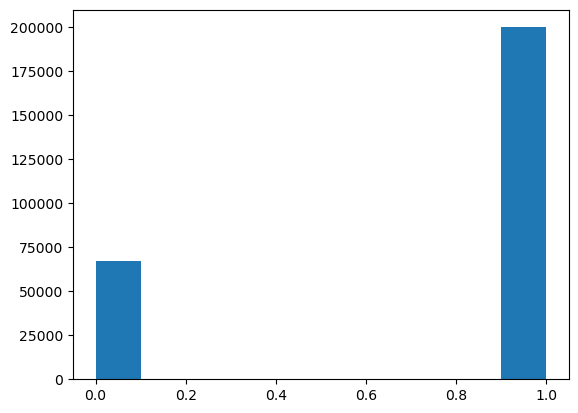

In [8]:
plt.hist(df_model.label)
plt.show()

Классы не сбалансированы.

In [9]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_model['text'], df_model['label'], stratify=df_model['label'])

count_vect = CountVectorizer().fit(train_x)

xtrain_count = count_vect.transform(train_x)
xvalid_count = count_vect.transform(valid_x)

hash_vec = HashingVectorizer().fit(train_x)
xtrain_has = hash_vec.transform(train_x)
xvalid_has = hash_vec.transform(valid_x)

tfidf_vec = TfidfVectorizer().fit(train_x)
xtrain_tfidf = tfidf_vec.transform(train_x)
xvalid_tfidf = tfidf_vec.transform(valid_x)

tfidf_vec_ngrams = TfidfVectorizer(ngram_range=(1, 3)).fit(train_x)
xtrain_tfidf_ngram = tfidf_vec_ngrams.transform(train_x)
xvalid_tfidf_ngram = tfidf_vec_ngrams.transform(valid_x)

In [10]:
#функция для построения модели на данных с различными способами векторизации
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [11]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier на Hashing Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_has, train_y, xvalid_has)
print("LR, HashingVectorizer: ", accuracy)

# Linear Classifier на Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier на Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

LR, Count Vectors:  0.9748678239249929
LR, HashingVectorizer:  0.9726511600041937
LR, WordLevel TF-IDF:  0.9732951907379394
LR, N-Gram Vectors:  0.9708538649332754


Лучшие результаты у логистической регрессии на Count Vectors. Также сохранение модели в файл.

In [12]:
model = linear_model.LogisticRegression().fit(xtrain_count, train_y)

with open("data/model_lr.pkl", "wb") as f:
    pickle.dump(model, f)

### Обучение W2V на продуктовых запросах

In [13]:
sentences_prod = []
c = 2*len(df_prod)

for i in range(0, c):
    sentences_prod.append(df.text.loc[i])

In [14]:
# Обучим модель word2vec на наших вопросах
sentences_prod = [i for i in sentences_prod if len(i) > 2]
model_prod = Word2Vec(sentences=sentences_prod, vector_size=100, min_count=1, window=5)
model_prod.save("data/w2v_model_prod")

In [15]:
#построение индекса
index_prod = annoy.AnnoyIndex(100 ,'angular')

index_map_prod = {}
counter = 0

for i in range(0, len(df_prod)):
    n_w2v = 0
    n_w2v_des = 0
    index_map_prod[counter] = ' '.join([str(df_prod.product_id.loc[i]), str(df_prod.title.loc[i])])
    index_map_prod[counter+len(df_prod)] = ' '.join([str(df_prod.product_id.loc[i]), str(df_prod.title.loc[i])])
    text = preprocess_txt(df_prod.title.loc[i])
    text_des = preprocess_txt(df_prod.descrirption.loc[i])
    vector = np.zeros(100)
    vector_des = np.zeros(100)
    for word in text:
        if word in model_prod.wv:
            vector += model_prod.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    for word in text_des:
        if word in model_prod.wv:
            vector_des += model_prod.wv[word]
            n_w2v_des += 1
    if n_w2v_des > 0:
        vector_des = vector_des / n_w2v_des
    index_prod.add_item(counter, vector)
    index_prod.add_item(counter+len(df_prod), vector_des)
            
    counter += 1

index_prod.build(10)
index_prod.save('data/prod.ann')

True

### Обучение W2V на вопросах из болталки

In [16]:
sentences_quest = []
c = 2*len(df_prod)

for i in range(c, len(df)):
    sentences_quest.append(df.text.loc[i])

In [17]:
# Обучим модель word2vec на наших вопросах
sentences_quest = [i for i in sentences_quest if len(i) > 2]
model_quest = Word2Vec(sentences=sentences_quest, vector_size=100, min_count=1, window=5)
model_quest.save("data/w2v_model_quest")

In [18]:
index_quest = annoy.AnnoyIndex(100 ,'angular')

index_map_quest = {}
counter = 0

for i in range(0, len(df_question)):
    n_w2v = 0
    index_map_quest[counter] = df_question.answer.loc[i]
    question = preprocess_txt(df_question.question.loc[i])
    vector = np.zeros(100)
    for word in question:
        if word in model_quest.wv:
            vector += model_quest.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    index_quest.add_item(counter, vector)
            
    counter += 1

index_quest.build(10)
index_quest.save('data/speaker.ann')

True

### Функции для обработки продуктовых запросов, вопросов из болталки и общая функция обработки входящих запросов.

In [78]:

def product(txt):    
    n_w2v = 0
    vector = np.zeros(100)
    for word in txt:
        if word in model_prod.wv:
            vector += model_prod.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index_prod.get_nns_by_vector(vector, 1)
    return index_map_prod[answer_index[0]]

In [79]:

def question(txt):    
    n_w2v = 0
    vector = np.zeros(100)
    for word in txt:
        if word in model_quest.wv:
            vector += model_quest.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index_quest.get_nns_by_vector(vector, 1)
    return index_map_quest[answer_index[0]]

In [89]:
def get_answer(txt):
    preprocessed_text = preprocess_txt(txt)
    preprocessed_text_model = ' '.join(str(i) for i in preprocessed_text)
    with open("data/model_lr.pkl", "wb") as f:
        pickle.dump(model, f)
    preprocessed_text_model = count_vect.transform([preprocessed_text_model])
    predictions = model.predict(preprocessed_text_model)
    if predictions[0]==0:
        return product(preprocessed_text)
    if predictions[0]==1:
        return question(preprocessed_text)

In [95]:
get_answer('Юбка детская ORBY').startswith('58e3cfe6132ca50e053f5f82')

True

In [96]:
not get_answer('Где ключи от танка').startswith('5')

True